In [1]:
# pip install git+https://www.github.com/keras-team/keras-contrib.git

In [2]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import glob
import datetime
from typing import AnyStr, Any, Callable

%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from keras import backend as K
from keras import Sequential, Model, initializers, regularizers, constraints
from keras.applications import vgg19
from keras.layers import Layer, Add, InputSpec, Activation, Conv2D, UpSampling2D, Input, Concatenate, InputLayer, Flatten
from keras.models import load_model
from keras_contrib.layers import InstanceNormalization


plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
mean_squared_error = tf.keras.losses.MeanSquaredError()

/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

In [4]:
def showInRow(list_of_images):
    count = len(list_of_images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx+1)
        img = list_of_images[idx]
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(img, cmap=cmap)
        plt.xticks([]), plt.yticks([])
    plt.show()

In [5]:
class VGG19(object):
    def __init__(self):
        vgg_layers = vgg19.VGG19(weights='imagenet').layers
        self.model = Model(inputs = [vgg_layers[0].input], 
                           outputs = [vgg_layers[2].output, vgg_layers[5].output, 
                                      vgg_layers[10].output, vgg_layers[15].output])
        self.vgg_layers = vgg_layers
        for layer in self.model.layers:
            layer.trainable = False

    def __call__(self, X):
        res = self.model(X)
        return res

In [6]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        return s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3]

    def call(self, x):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')

In [7]:
class ConvLayer(object):
    def __init__(self, out_channels, kernel_size, stride, **kwargs):
        reflection_padding = kernel_size // 2
        
        self.reflection_pad = ReflectionPadding2D((reflection_padding, reflection_padding))
        self.conv2d = Conv2D(out_channels, kernel_size = kernel_size, strides = stride)

    def __call__(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [8]:
class ResidualBlock(object):
    def __init__(self, channels):
        self.conv1 = ConvLayer(channels, kernel_size=3, stride=1)
        self.in1 = InstanceNormalization(3)
        self.conv2 = ConvLayer(channels, kernel_size=3, stride=1)
        self.in2 = InstanceNormalization(3)
        self.relu = Activation('relu')
        self.add = Add()

    def __call__(self, x):
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = self.add([out, x])
        return out

In [9]:
class UpsampleConvLayer(object):
    def __init__(self, out_channels, kernel_size, stride, upsample):   
        self.upsample_layer = UpSampling2D(upsample)
        self.conv = ConvLayer(out_channels, kernel_size=kernel_size, stride=stride)
    
    def __call__(self, x):
        out = self.upsample_layer(x)
        out = self.conv(out)
        return out

In [10]:
class StylizerNet(object):
    def __init__(self):
        # Initial convolution layers
        self.conv1 = ConvLayer(32, kernel_size=9, stride=1)
        self.in1 = InstanceNormalization(3)
        self.conv2 = ConvLayer(64, kernel_size=3, stride=2)
        self.in2 = InstanceNormalization(3)
        self.conv3 = ConvLayer(128, kernel_size=3, stride=2)
        self.in3 = InstanceNormalization(3)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(64, kernel_size=3, stride=1, upsample=2)
        self.in4 = InstanceNormalization(3)
        self.deconv2 = UpsampleConvLayer(32, kernel_size=3, stride=1, upsample=2)
        self.in5 = InstanceNormalization(3)
        self.deconv3 = ConvLayer(3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = Activation('relu')

    def __call__(self, x):
        y = self.relu(self.in1(self.conv1(x))) # 32
        y = self.relu(self.in2(self.conv2(y))) # 64
        y = self.relu(self.in3(self.conv3(y))) # 128
        
        y = self.res1(y) # 128
        y = self.res2(y) # 128
        y = self.res3(y) # 128
        y = self.res4(y) # 128
        y = self.res5(y) # 128
        
        y = self.relu(self.in4(self.deconv1(y))) 
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y

In [11]:
def preprocess_image(img, img_size):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if (img.shape[0] < img.shape[1]):
        f = img_size * img.shape[1] // img.shape[0]
        img = cv2.resize(img, (f, img_size))
    else:
        f = img_size * img.shape[0] // img.shape[1]
        img = cv2.resize(img, (img_size, f))
    
    (h, w) = img.shape[:2]
    
    d = img_size // 2
    img = img[h // 2 - d:h // 2 + d, w // 2 - d:w // 2 + d]
    
    return img

def load_image(file, img_size):
    img = cv2.imread(file)
    return preprocess_image(img, img_size)

In [12]:
def gram_matrix(y):
    shape = tf.shape(y)
    
    b = shape[0]
    h = shape[1]
    w = shape[2]
    ch = shape[3]
    
    features = tf.reshape(y, (b, w * h, ch))
    features_t = tf.transpose(features, (0, 2, 1))
    gram = tf.matmul(features_t, features) / tf.cast(ch * h * w, tf.float32)
    return gram

In [13]:
def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = tf.reshape(tf.constant([0.485, 0.456, 0.406], dtype=tf.float32), (1, 1, 1, -1))
    std = tf.reshape(tf.constant([0.229, 0.224, 0.225], dtype=tf.float32), (1, 1, 1, -1))
    batch = batch / 255.0
    return (batch - mean) / std

In [14]:
def transform(img):
    return tf.constant(np.array([img]), dtype=tf.float32)

In [15]:
STYLE_IMAGE = "styles/the_scream.jpg"
BATCH_SIZE = 16
IMG_SIZE = 224
STYLE_WEIGHT = 2000
TV_WEIGHT = 1e-5
TO_TRAIN = False

In [16]:
def get_loss():
    vgg = VGG19()
    style_image = load_image(STYLE_IMAGE, IMG_SIZE)
    style_image = transform(style_image) # (1, h, w, ch)

    style_image = K.repeat_elements(style_image, BATCH_SIZE, 0)
    feat_style = vgg(normalize_batch(style_image))
    gram_style = [gram_matrix(y) for y in feat_style] # [(1, ch, ch)]
    
    def loss(y_true, y_pred):
        batch_size = tf.shape(y_true)[0]
        feat_true = vgg(normalize_batch(y_true))
        feat_pred = vgg(normalize_batch(y_pred))
        
        content_loss = mean_squared_error(feat_true[2], feat_pred[2])
        
        style_loss = 0.0
        gram_pred = [gram_matrix(y) for y in feat_pred] # [(batch, ch, ch)]
        for gm_pred, gm_style in zip(gram_pred, gram_style):
            style_loss += mean_squared_error(gm_pred, gm_style[:batch_size])
        style_loss *= STYLE_WEIGHT
        
        tv_loss = TV_WEIGHT * (K.mean((y_pred[:,:,1:,:]-y_pred[:,:,:-1,:])**2)+K.mean((y_pred[:,1:,:,:]-y_pred[:,:-1,:,:])**2))
        
        total_loss = content_loss + tv_loss + style_loss
        return total_loss
    return loss

In [17]:
stylizer_inp = Input((224, 224, 3))
stylizer = StylizerNet()(stylizer_inp)
stylizer = Model(stylizer_inp, stylizer)

In [18]:
stylizer.compile(loss=get_loss(), optimizer='adam')

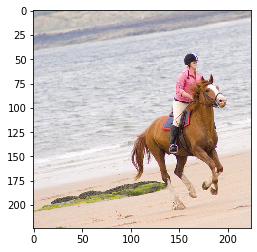

In [19]:
validation_img = np.array([load_image('train2017/000000515895.jpg', IMG_SIZE)])
plt.imshow(validation_img[0])

In [20]:
def prepare_stylized_image(imgs):
    return np.clip(imgs, 0, 255).astype(np.uint8)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

2019-11-17 19:32:23.254597 It: 0 out of 2501	loss: 6018.8994140625


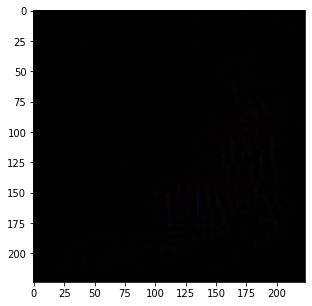

2019-11-17 19:32:53.130592 It: 50 out of 2501	loss: 1389.272705078125
2019-11-17 19:33:20.239992 It: 100 out of 2501	loss: 903.0086059570312
2019-11-17 19:33:47.240499 It: 150 out of 2501	loss: 781.123046875
2019-11-17 19:34:14.310824 It: 200 out of 2501	loss: 727.9697265625
2019-11-17 19:34:41.299552 It: 250 out of 2501	loss: 668.202880859375
2019-11-17 19:35:08.279673 It: 300 out of 2501	loss: 617.3145141601562
2019-11-17 19:35:35.317495 It: 350 out of 2501	loss: 580.856689453125
2019-11-17 19:36:02.291867 It: 400 out of 2501	loss: 516.6188354492188
2019-11-17 19:36:29.318620 It: 450 out of 2501	loss: 549.0838623046875
2019-11-17 19:36:56.498837 It: 500 out of 2501	loss: 515.3718872070312


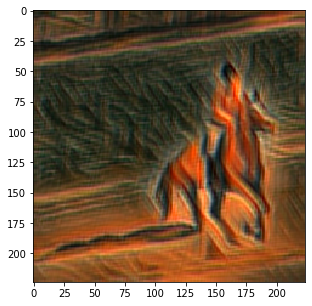

2019-11-17 19:37:23.986334 It: 550 out of 2501	loss: 502.0025329589844
2019-11-17 19:37:50.991245 It: 600 out of 2501	loss: 448.9457092285156
2019-11-17 19:38:18.248751 It: 650 out of 2501	loss: 432.7001953125
2019-11-17 19:38:45.172721 It: 700 out of 2501	loss: 437.93487548828125
2019-11-17 19:39:12.138020 It: 750 out of 2501	loss: 470.03485107421875
2019-11-17 19:39:39.317238 It: 800 out of 2501	loss: 431.79052734375
2019-11-17 19:40:06.253477 It: 850 out of 2501	loss: 436.2024230957031
2019-11-17 19:40:33.276511 It: 900 out of 2501	loss: 426.92474365234375
2019-11-17 19:41:00.253299 It: 950 out of 2501	loss: 425.24383544921875
2019-11-17 19:41:27.195089 It: 1000 out of 2501	loss: 421.6466979980469


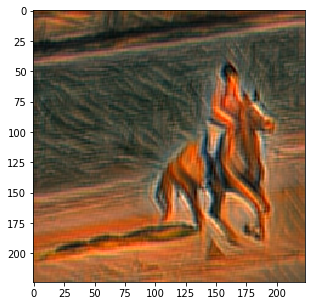

2019-11-17 19:41:54.453152 It: 1050 out of 2501	loss: 406.72442626953125
2019-11-17 19:42:21.431527 It: 1100 out of 2501	loss: 406.6385803222656
2019-11-17 19:42:48.313445 It: 1150 out of 2501	loss: 389.69830322265625
2019-11-17 19:43:15.232366 It: 1200 out of 2501	loss: 406.8245544433594
2019-11-17 19:43:42.203488 It: 1250 out of 2501	loss: 397.76983642578125
2019-11-17 19:44:09.203282 It: 1300 out of 2501	loss: 398.26824951171875
2019-11-17 19:44:36.232229 It: 1350 out of 2501	loss: 408.867431640625
2019-11-17 19:45:03.191291 It: 1400 out of 2501	loss: 419.717529296875
2019-11-17 19:45:30.071135 It: 1450 out of 2501	loss: 405.2795715332031
2019-11-17 19:45:57.135997 It: 1500 out of 2501	loss: 389.9173583984375


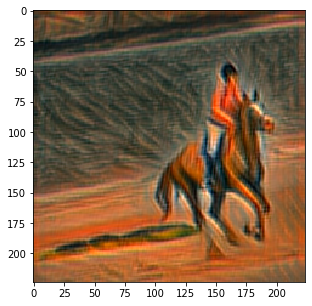

2019-11-17 19:46:24.582994 It: 1550 out of 2501	loss: 413.03668212890625
2019-11-17 19:46:51.537846 It: 1600 out of 2501	loss: 386.9580383300781
2019-11-17 19:47:18.480923 It: 1650 out of 2501	loss: 404.9793701171875
2019-11-17 19:47:45.316750 It: 1700 out of 2501	loss: 379.6162109375
2019-11-17 19:48:12.220561 It: 1750 out of 2501	loss: 386.0810546875
2019-11-17 19:48:39.073557 It: 1800 out of 2501	loss: 372.8780517578125
2019-11-17 19:49:05.933324 It: 1850 out of 2501	loss: 362.6243896484375
2019-11-17 19:49:32.871343 It: 1900 out of 2501	loss: 368.66046142578125
2019-11-17 19:49:59.669447 It: 1950 out of 2501	loss: 363.3047790527344
2019-11-17 19:50:26.542119 It: 2000 out of 2501	loss: 373.2273254394531


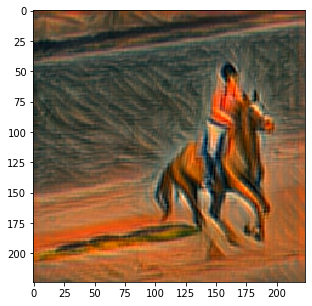

2019-11-17 19:50:53.770849 It: 2050 out of 2501	loss: 357.39337158203125
2019-11-17 19:51:20.655033 It: 2100 out of 2501	loss: 364.4266357421875
2019-11-17 19:51:47.513230 It: 2150 out of 2501	loss: 339.9300537109375
2019-11-17 19:52:14.392761 It: 2200 out of 2501	loss: 365.93585205078125
2019-11-17 19:52:41.250322 It: 2250 out of 2501	loss: 348.4824523925781
2019-11-17 19:53:08.158328 It: 2300 out of 2501	loss: 358.51123046875
2019-11-17 19:53:35.027123 It: 2350 out of 2501	loss: 343.5224609375
2019-11-17 19:54:01.913864 It: 2400 out of 2501	loss: 360.69805908203125
2019-11-17 19:54:28.794330 It: 2450 out of 2501	loss: 341.4839782714844
2019-11-17 19:54:55.644760 It: 2500 out of 2501	loss: 335.16827392578125


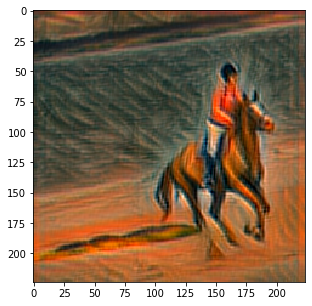

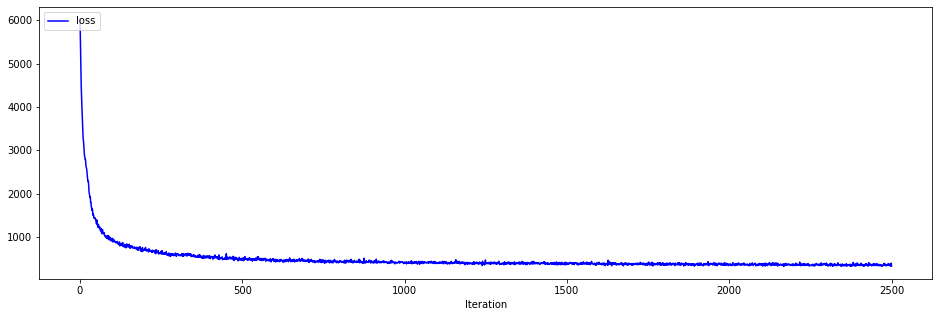

In [22]:
if TO_TRAIN:
    losses = []
    
    file_names = glob.glob('train2017/*.jpg')
    n = 2501  # len(file_names) // BATCH_SIZE
    
    plt.rcParams["figure.figsize"] = (16, 5) # (w, h)
    
    with open("loss.txt", "w", encoding="utf-8") as f:
        for it in range(n):
            start = it * BATCH_SIZE
            end = (it + 1) * BATCH_SIZE
            samples = np.array([load_image(file_name, IMG_SIZE) for file_name in file_names[start:end]])

            loss = stylizer.train_on_batch(samples, samples)
            losses.append(loss)

            if it % 50 == 0:
                text = f'{datetime.datetime.now()} It: {it} out of {n}\tloss: {loss}'
                f.write(text + '\n')
                print(text)
            if it % 500 == 0:
                stylizer.save(f"models/model-{it}.ckpt")
                pred = stylizer.predict(validation_img)[0]
                pred = prepare_stylized_image(pred)
                plt.imshow(pred)
                plt.show()
    
    plt.plot(losses, '-b', label='loss')

    plt.xlabel("Loss")
    plt.xlabel("Iteration")
    plt.legend(loc='upper left')

    plt.savefig("loss.png")
    plt.show()

In [21]:
glob.glob('model-*.ckpt')

['model-candy-style2k-b2500.ckpt',
 'model-candy-style4k-b2500.ckpt',
 'model-feathers-style1000-b2500.ckpt',
 'model-feathers-style10k-b2500.ckpt',
 'model-feathers-style4k-b2500.ckpt',
 'model-lamuse-style4k-b2500.ckpt',
 'model-lamuse-style6k-b2500.ckpt',
 'model-scream-style2000-b2500.ckpt',
 'model-starrynight-style6k-b2000.ckpt']

In [22]:
model = 'model-scream-style2000-b2500.ckpt'
if TO_TRAIN:
    stylizer.save(model)
else:
    stylizer.load_weights(model)

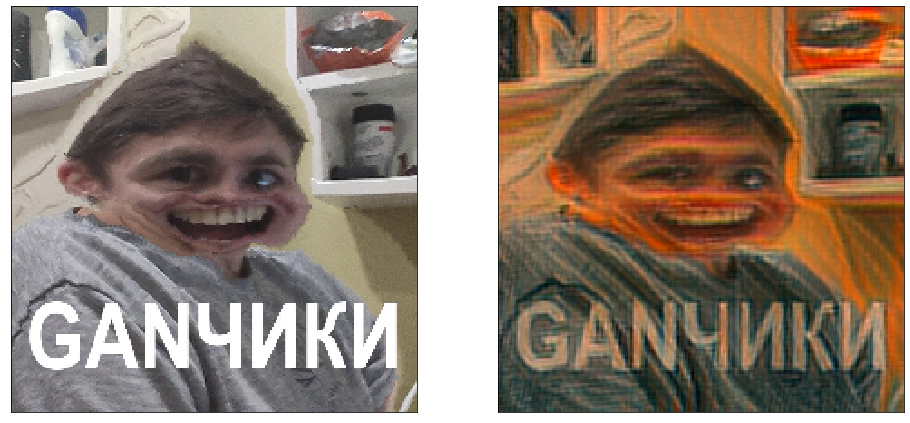

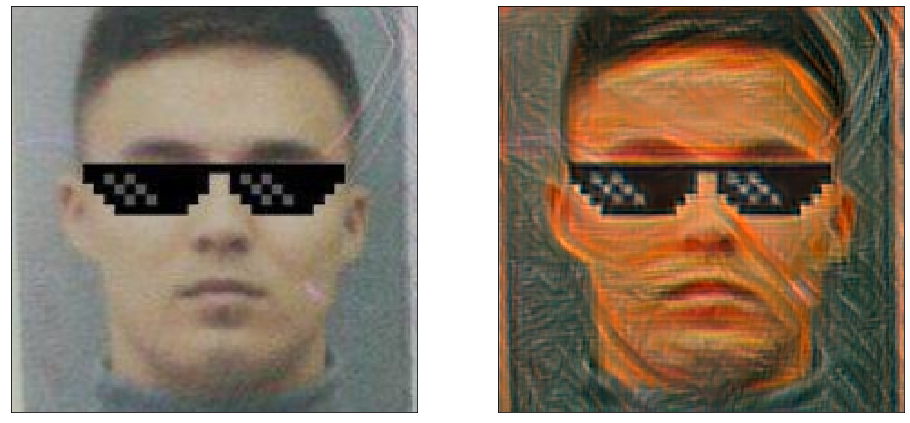

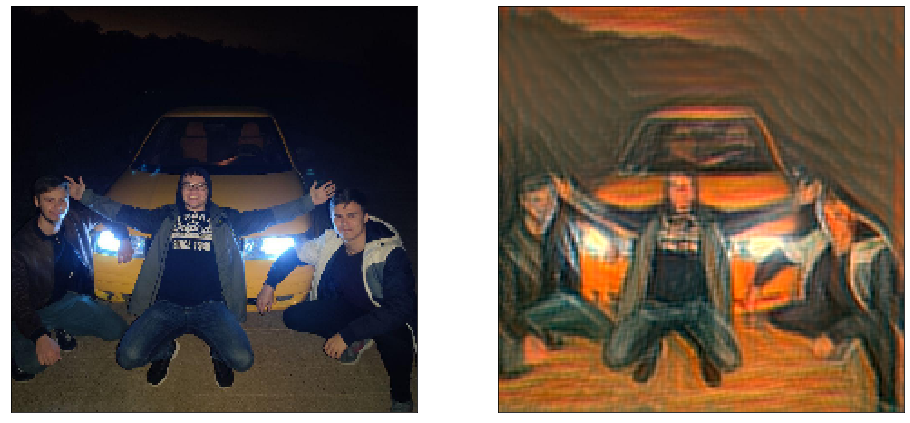

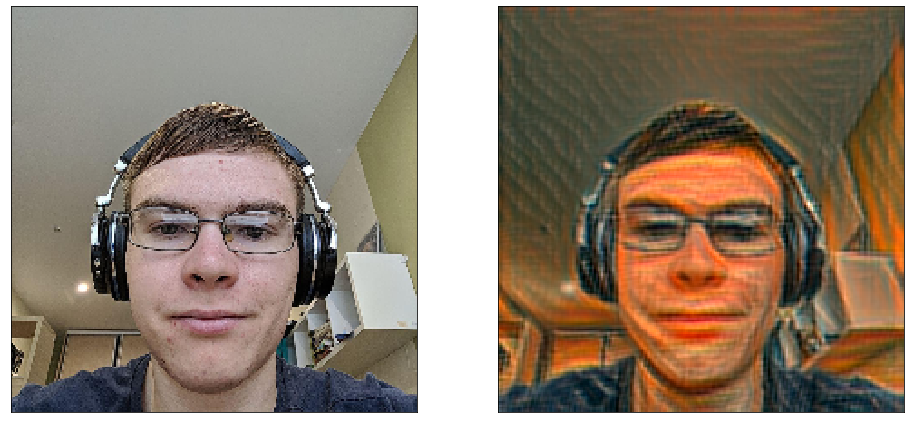

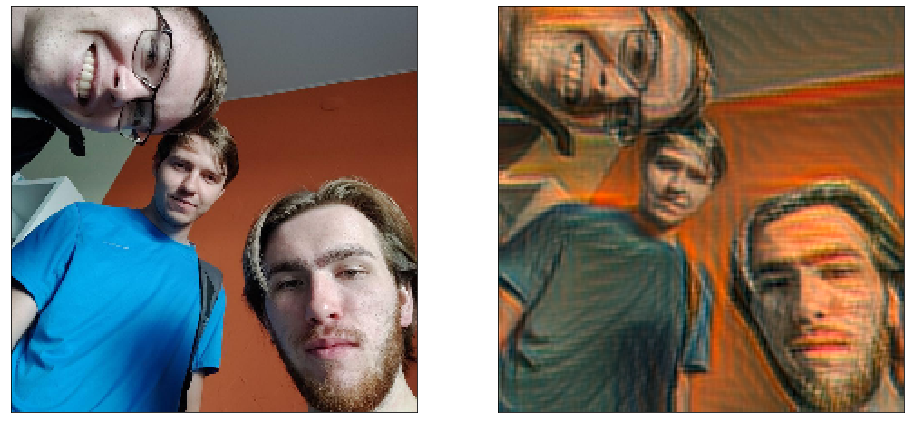

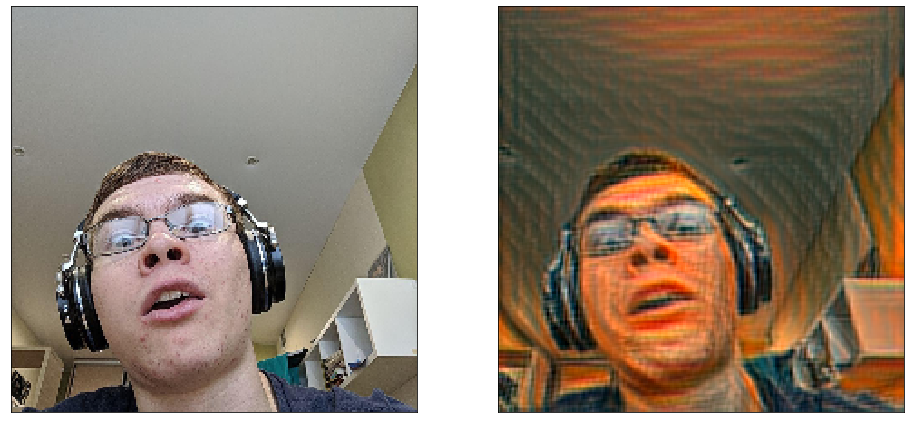

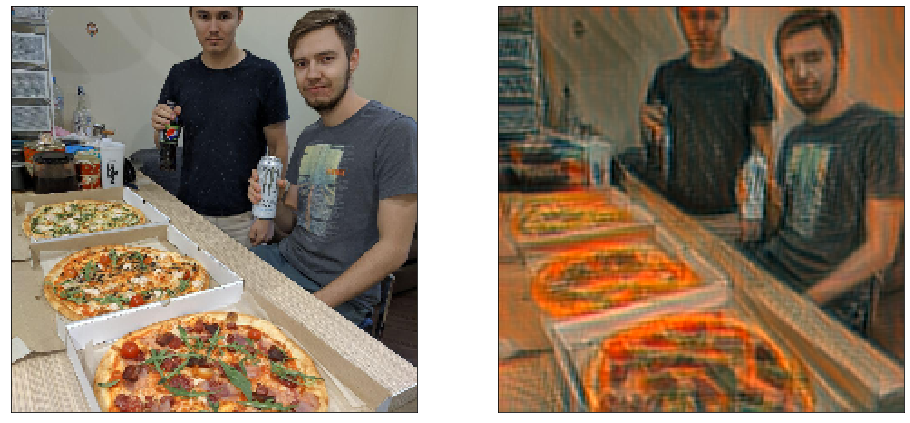

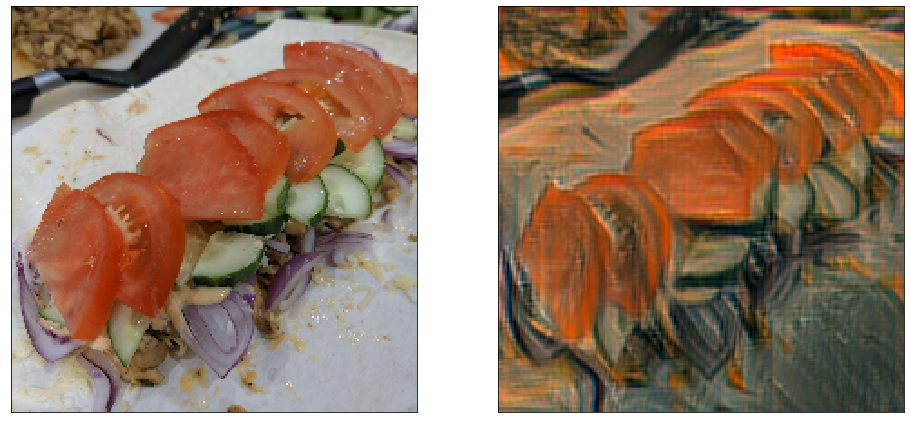

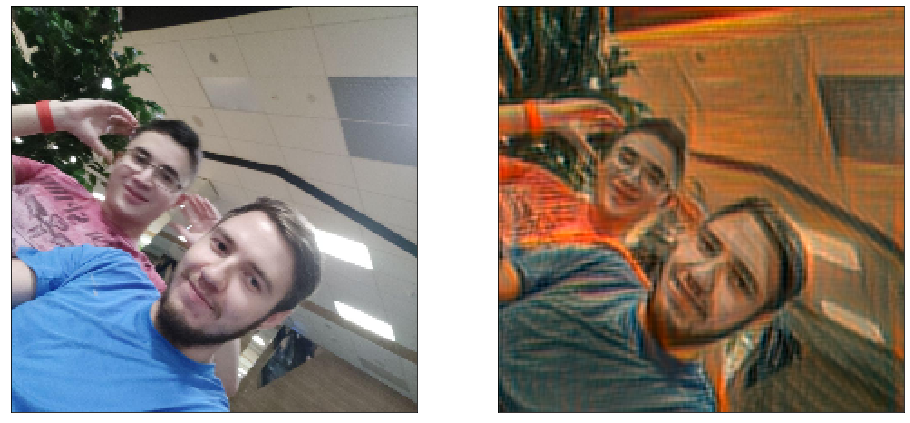

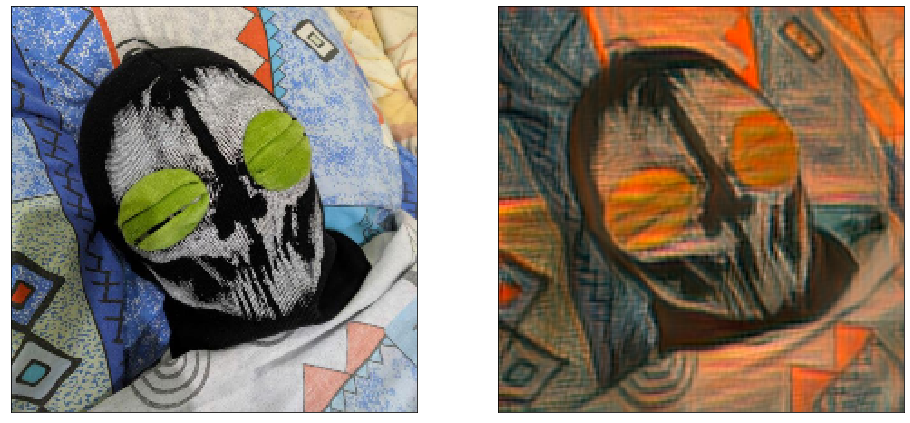

In [23]:
img_names = glob.glob('test/*')
imgs = np.array([load_image(f, IMG_SIZE) for f in img_names])
preds = stylizer.predict(imgs)

plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
for img, pred in zip(imgs, preds):
    pred = prepare_stylized_image(pred)
    showInRow([img, pred])

In [24]:
def process_video(video_path, frames_process, batch_size, show=False):
    vid = cv2.VideoCapture(video_path)
    
    try:
        fps = int(vid.get(cv2.CAP_PROP_FPS))
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(f'out-{video_path}', fourcc, fps, (IMG_SIZE, IMG_SIZE))

        while(True):
            batch = []
            for i in range(batch_size):
                ret, frame = vid.read()
                if not ret:
                    break
                batch.append(preprocess_image(frame, IMG_SIZE))

            if not batch:
                out.release()
                vid.release()
                break

            if frames_process is not None:
                frames = frames_process(np.array(batch))

            for img, pred in zip(batch, frames):
                pred = prepare_stylized_image(pred)
                
                if show:
                    showInRow([img, pred])
                    clear_output(wait=True)

                pred = cv2.cvtColor(pred, cv2.COLOR_RGB2BGR)
                out.write(pred)
    except KeyboardInterrupt:
        out.release()
        vid.release()

In [26]:
process_video("videos/video.mp4", stylizer.predict, 25, show=False)